In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error 
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [2]:
local_path = "D:/Prashant/LEARNING/UPX/ML/Project/Airquality/"

# Data Wrangling

In [3]:
#Read Data into dataframe
data = pd.read_csv(local_path+'AirQualityUCI.csv')

In [4]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
Date             9357 non-null object
Time             9357 non-null object
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
Unnamed: 15      0 non-null float64
Unnamed: 16      0 non-null float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


As per above info last 2 columns are null.

In [6]:
#Replace -200.0 as null
data.replace(value=np.nan,to_replace=-200.0,inplace=True)

In [7]:
#drop all rows having all attributes as null
data.dropna(how='all',axis='rows',inplace=True)

In [8]:
#drop all columns having atlease 50% values as null
data.dropna(how='all',axis='columns',thresh=len(data)/2,inplace=True)

In [9]:
#drop all rows having more than 9 attributes as null
data.dropna(how='all',axis='rows',thresh=9,inplace=True)

In [10]:
#Extract Hour from Time and add to dataframe
data['HR'] = data['Time'].apply(  lambda x: int(x.split(':')[0])  )
#Extract Day from Date and add to dataframe
data['DAY'] = data['Date'].apply(  lambda x: int(x.split('/')[1])  )
#Extract Month from Date and add to dataframe
data['MONTH'] = data['Date'].apply(  lambda x: int(x.split('/')[0])  )

In [11]:
print('Count of missing values:\n',data.shape[0]-data.count())

Count of missing values:
 Date                0
Time                0
CO(GT)           1647
PT08.S1(CO)         0
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)          1595
PT08.S3(NOx)        0
NO2(GT)          1598
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
HR                  0
DAY                 0
MONTH               0
dtype: int64


In [12]:
#fill missing values
data.fillna(data.groupby(by=['MONTH','DAY']).transform('mean'),inplace=True)
data.fillna(data.groupby(by=['MONTH','HR']).transform('mean'),inplace=True)
data.fillna(data.groupby(by=['HR']).transform('mean'),inplace=True)

In [13]:
print('Count of missing values:\n',data.shape[0]-data.count())

Count of missing values:
 Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
HR               0
DAY              0
MONTH            0
dtype: int64


In [14]:
#Function to detect outliers and returns indices

def detect_outliers(df,n,features):
    outlier_indices=[]
    for col in features:
        Q3=df[col].quantile(.75)
        Q1=df[col].quantile(.25)
        IQR=Q3-Q1
        
        outlier_range = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_range) | (df[col] > Q3 + outlier_range )].index
        
        
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    print(multiple_outliers)
    
    return multiple_outliers

In [15]:
#find outliers
Outliers_to_drop = detect_outliers(data,3,
['CO(GT)','PT08.S1(CO)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH'])

[50, 111, 120, 121, 122, 159, 169, 170, 183, 207, 518, 638, 865, 1165, 1190, 1201, 1502, 1646, 1670, 1694, 2174, 4657, 4670, 4742, 4848, 4849, 4895, 5065, 5066, 5366, 5375, 5376, 5377, 5401, 5424, 5495, 5496, 5497, 5519, 5520, 5521, 5684, 5687, 5688, 5689, 5690, 5736, 5751, 5759, 5760, 6047, 6048, 6049, 6168, 6169, 6170, 6184, 6188, 6191, 6192, 6193, 6194, 6195, 6262, 6263, 6264, 6265, 6266, 6267, 6329, 6408, 6409, 6410, 6671, 6672, 6673, 6688, 6912, 6913, 6914, 6915, 7218, 7512, 7513, 7611, 7849, 7850, 7911, 7920, 7921, 8138, 8857, 8881, 8882, 9025, 9073, 9074, 9098, 998, 4992, 4993, 5016, 5017, 5041, 5054, 5735, 7610, 8136, 8137, 8139, 8140, 8141, 8142, 3158, 6159, 6160]


In [16]:
#dropping outliers
data.drop(index=Outliers_to_drop,axis='rows',inplace=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8875 entries, 0 to 9356
Data columns (total 17 columns):
Date             8875 non-null object
Time             8875 non-null object
CO(GT)           8875 non-null float64
PT08.S1(CO)      8875 non-null float64
C6H6(GT)         8875 non-null float64
PT08.S2(NMHC)    8875 non-null float64
NOx(GT)          8875 non-null float64
PT08.S3(NOx)     8875 non-null float64
NO2(GT)          8875 non-null float64
PT08.S4(NO2)     8875 non-null float64
PT08.S5(O3)      8875 non-null float64
T                8875 non-null float64
RH               8875 non-null float64
AH               8875 non-null float64
HR               8875 non-null int64
DAY              8875 non-null int64
MONTH            8875 non-null int64
dtypes: float64(12), int64(3), object(2)
memory usage: 1.2+ MB


# EDA

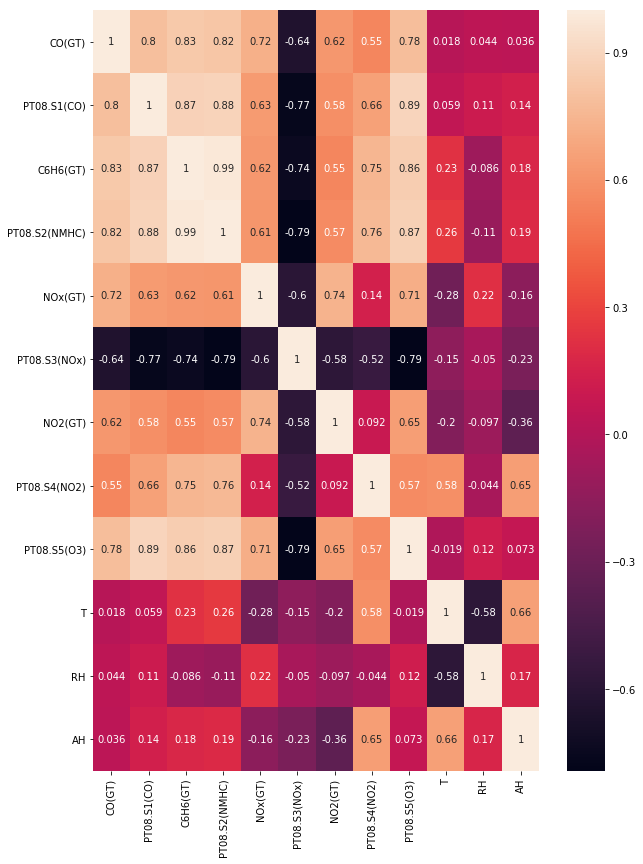

In [18]:
#find correlation between attributes
plt.figure(figsize=(10,14))
sns.heatmap(data[['CO(GT)','PT08.S1(CO)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH']].corr(),annot=True)
plt.show()

In [19]:
#'C6H6(GT)','PT08.S2(NMHC)' are highly correlated hence dropping 'C6H6(GT)'
data.drop(columns=['C6H6(GT)'],inplace=True)

# EDA -  Bivariate Analysis in terms of Relative Humidity

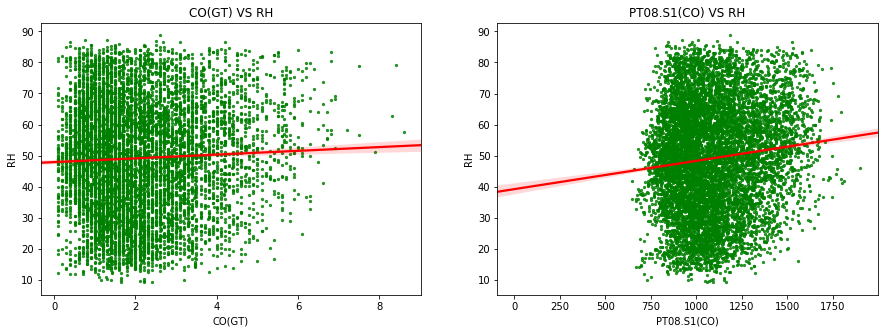

In [20]:

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15, 5)
ax1.set_title('CO(GT) VS RH')
ax2.set_title('PT08.S1(CO) VS RH')

sns.regplot('CO(GT)', 'RH', data=data, fit_reg=True,line_kws={'color': 'red'},scatter_kws={'color':'green','s':5},ax=ax1)
sns.regplot('PT08.S1(CO)', 'RH', data=data, fit_reg=True,line_kws={'color': 'red'},scatter_kws={'color':'green','s':5}, ax = ax2)

plt.show()

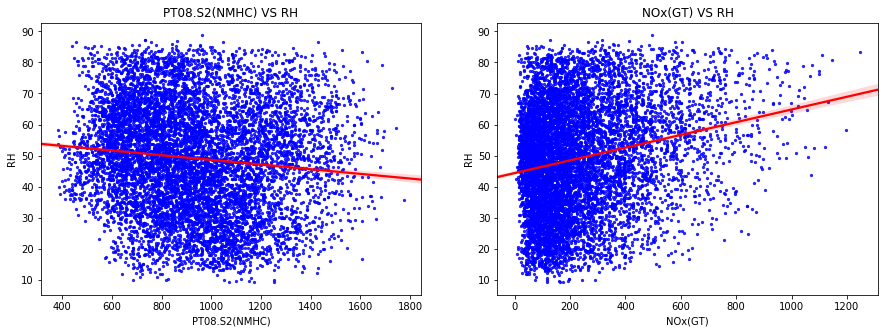

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15, 5)
ax1.set_title('PT08.S2(NMHC) VS RH')
ax2.set_title('NOx(GT) VS RH')

sns.regplot('PT08.S2(NMHC)', 'RH', data=data, fit_reg=True,line_kws={'color': 'red'},scatter_kws={'color':'blue','s':5},ax=ax1)
sns.regplot('NOx(GT)', 'RH', data=data, fit_reg=True,line_kws={'color': 'red'},scatter_kws={'color':'blue','s':5}, ax = ax2)

plt.show()

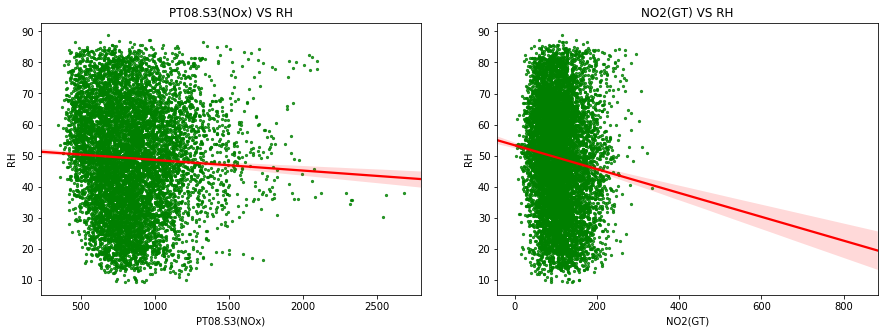

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15, 5)
ax1.set_title('PT08.S3(NOx) VS RH')
ax2.set_title('NO2(GT) VS RH')

sns.regplot('PT08.S3(NOx)', 'RH', data=data, fit_reg=True,line_kws={'color': 'red'},scatter_kws={'color':'green','s':5},ax=ax1)
sns.regplot('NO2(GT)', 'RH', data=data, fit_reg=True,line_kws={'color': 'red'},scatter_kws={'color':'green','s':5}, ax = ax2)

plt.show()

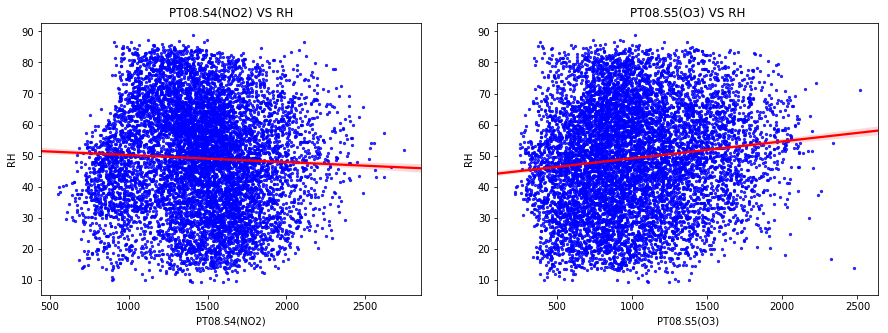

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15, 5)
ax1.set_title('PT08.S4(NO2) VS RH')
ax2.set_title('PT08.S5(O3) VS RH')

sns.regplot('PT08.S4(NO2)', 'RH', data=data, fit_reg=True,line_kws={'color': 'red'},scatter_kws={'color':'blue','s':5},ax=ax1)
sns.regplot('PT08.S5(O3)', 'RH', data=data, fit_reg=True,line_kws={'color': 'red'},scatter_kws={'color':'blue','s':5}, ax = ax2)

plt.show()

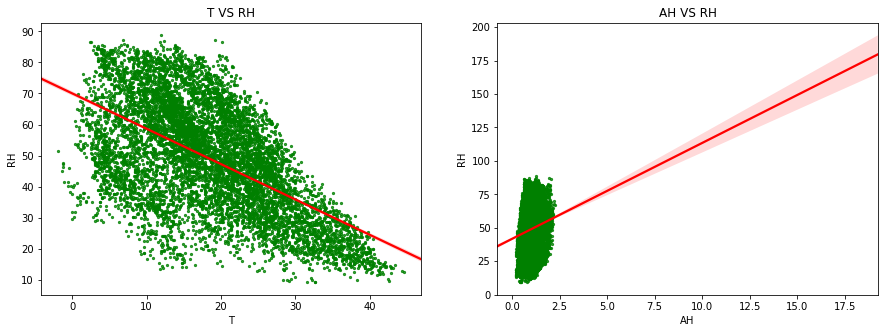

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15, 5)
ax1.set_title('T VS RH')
ax2.set_title('AH VS RH')

sns.regplot('T', 'RH', data=data, fit_reg=True,line_kws={'color': 'red'},scatter_kws={'color':'green','s':5},ax=ax1)
sns.regplot('AH', 'RH', data=data, fit_reg=True,line_kws={'color': 'red'},scatter_kws={'color':'green','s':5}, ax = ax2)

plt.show()

# ML

In [25]:
accuracy_score = {}
rmse_score = {}

In [26]:
#Define features x and target y
x = data.drop(columns=['Date','Time','RH'])
y = data['RH']

In [27]:
#StandardScaler
std_x = StandardScaler().fit_transform(x)

In [28]:
#Split into train and test
X_train, X_test, y_train, y_test=train_test_split(std_x,y,test_size=0.3, random_state=1234)

Linear Regression Model

In [29]:
#Fit Linear Regression Model
LR = LinearRegression()
LR.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
#cross validate LR Model
scores_LR = cross_val_score(LR, X_test, y_test, cv=5)
print(scores_LR)   
print("Accuracy Score LR: %0.2f (+/- %0.2f)" % (scores_LR.mean(), scores_LR.std() * 2))

[0.88129641 0.87459576 0.8826923  0.88600888 0.88372587]
Accuracy Score LR: 0.88 (+/- 0.01)


In [31]:
#Calculate RMSE of model
y_pred=LR.predict(X_test) 
rmse_LR=np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE of LR model:',rmse_LR)

RMSE of LR model: 5.9174057306753705


In [32]:
accuracy_score['LR']=scores_LR.mean()
rmse_score['LR']=rmse_LR

Decision Tree

In [33]:
#Decision Tree
dtr = tree.DecisionTreeRegressor()
dtr = dtr.fit(X_train,y_train)


In [34]:
scores_dt = cross_val_score(dtr, X_test, y_test, cv=5)
print(scores_dt)   
print("Accuracy of Decision Tree: %0.2f (+/- %0.2f)" % (scores_dt.mean(), scores_dt.std() * 2))

[0.98654845 0.98249627 0.98413902 0.97738097 0.98193337]
Accuracy of Decision Tree: 0.98 (+/- 0.01)


In [35]:
y_pred=dtr.predict(X_test) 
rmse_dtr=np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE of model:',rmse_dtr)

RMSE of model: 1.308890997757458


In [36]:
accuracy_score['DT']=scores_dt.mean()
rmse_score['DT']=rmse_dtr

Random Forest

In [37]:
#Random Forest Model

regr = RandomForestRegressor()
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [38]:
scores_rf = cross_val_score(regr, X_test, y_test, cv=5)
print(scores_rf)   
print("Accuracy of Random Forest: %0.2f (+/- %0.2f)" % (scores_rf.mean(), scores_rf.std() * 2))

[0.99414569 0.99271214 0.99368876 0.99227006 0.98975453]
Accuracy of Random Forest: 0.99 (+/- 0.00)


In [39]:
y_pred=regr.predict(X_test) 
rmse_rf=np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE of Random Forest model:',rmse_rf)

RMSE of Random Forest model: 0.786284464733844


In [40]:
accuracy_score['RF']=scores_rf.mean()
rmse_score['RF']=rmse_rf

Support Vector Machine

In [41]:
#Support Vector Regressor
svr = SVR()
svr.fit(X_train,y_train) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [42]:
scores_svr = cross_val_score(svr, X_test, y_test, cv=5)
print(scores_svr)   
print("Accuracy of SVR: %0.2f (+/- %0.2f)" % (scores_svr.mean(), scores_svr.std() * 2))

[0.86416401 0.871026   0.88870159 0.87343651 0.85647253]
Accuracy of SVR: 0.87 (+/- 0.02)


In [43]:
y_pred=svr.predict(X_test) 
rmse_svr=np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE of svr model:',rmse_svr)

RMSE of svr model: 3.9021404392344086


In [44]:
accuracy_score['SVM']=scores_svr.mean()
rmse_score['SVM']=rmse_svr

XGBoost

In [45]:
#xgboost regressor
xgb = XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [46]:
scores_xgb = cross_val_score(xgb, X_test, y_test, cv=5)
print(scores_xgb)   
print("Accuracy of XGBooster: %0.2f (+/- %0.2f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

[0.98908806 0.98700675 0.99048913 0.98801576 0.98794751]
Accuracy of XGBooster: 0.99 (+/- 0.00)


In [47]:
y_pred=xgb.predict(X_test) 
rmse_xgb=np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE of svr model:',rmse_xgb)

RMSE of svr model: 1.5739716479720276


In [48]:
accuracy_score['Boosting']=scores_xgb.mean()
rmse_score['Boosting']=rmse_xgb

# Model Evaluation

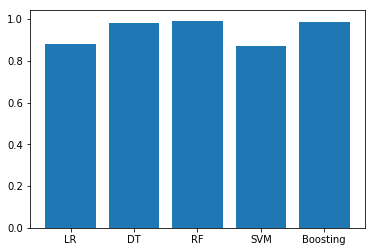

In [49]:
plt.bar(range(len(accuracy_score)), list(accuracy_score.values()), align='center')
plt.xticks(range(len(accuracy_score)), list(accuracy_score.keys()))

plt.show()

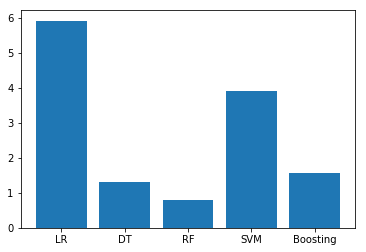

In [50]:
plt.bar(range(len(rmse_score)), list(rmse_score.values()), align='center')
plt.xticks(range(len(rmse_score)), list(rmse_score.keys()))

plt.show()

Conclusion: Random forest has high accuracy an least RMSE.